<a href="https://colab.research.google.com/github/LudovicoLentini/Clustering_Word_Cloud/blob/main/Clustering_Word_Cloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Clustering text documents using k-means and dimensionality reduction


This is an example showing how dimensionality reduction can mitigate the "curse of dimensionality", by denoising data and improving performance of euclidean-based clustering approaches. In this example, we cluster a set of documents, represented as bag-of-worids, using two approaches:
1. A standard k-means algorithm (k-means++)
2. We apply k-means after reducing the dimensionality of the space via application of a truncated SVD
3. We proceed as in point 2 above, this time using PCA

We use standard measures of clustering quality to compare results provided by the two approaches.

## Datasets
To test our ideas, we begin with some standard datasets, for which ```sklearn``` provides a class for automatic downloading and preprocessing.
As stated in the description, "The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training (or development) and the other one for testing (or for performance evaluation). The split between the train and test set is based upon a messages posted before and after a specific date." Please refer to http://scikit-learn.org/stable/datasets/index.html#the-20-newsgroups-text-dataset for more information.

To begin with, we import the libraries we will be using in this notebook:

## Our goal
Given a collection containing documents from $k$ different topics ($k = 3$ in this example), we want to extract the $10$ "most important" terms for each topic. We will consider 3 approaches:
1. The first is a pure clustering method: we treat each document as a point in feature space (features are the terms) and we apply a standard $k$-means algorithm. Each of the $k$ centroids thus obtained represents the "typical" document for the corresponding topic. We identify the terms that correspond to the $10$ largest entries.
2. The second is a purely SVD-based approach. We compute the first $k$ components of the SVD of the data matrix, setting $k$ to the number of topics in the subcollection we downloaded ($k = 3$ in this example). The underlying assumption is that the $k$ main singular vectors are correlated with the subcollection's topics. This turns out to be true in this example, although it does not have to always be the case.
3. The third is a hybrid approach, in which data are first projected onto a subspace in $k$ dimensions using an SVD, so that each original point $\mathbf{x}$ now corresponds to a vector $\hat{\mathbf{x}}$, with $\hat{\mathbf{x}}_i$ the component of $\hat{\mathbf{x}}$ along the $i$-th right singular vector. We then apply $k$-means to the projected points. The underlying idea is that the entries of vectors in projected space, corresponding to documents on the same topic, are correlated. After performing clustering, we again have $k$ centroids in projected space. We identify the points corresponding to these centroids in the original space (see following paragraphs about how this is done) and we then proceed like in point 1. above.

## How to proceed
We next describe the main steps for the implementation of the solutions mentioned above. Note that we are not implementing the obvious, naive solution, that directly uses the label/topic of each document to retrieve the most important words for each topic. It could be interesting to compare the results with those of this simple solution, based on the ground truth.

In [ ]:
import nltk
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans

import sys
from time import time

import numpy as np

import re # Regular expressions

The class ```TruncatedSVD``` implements truncated SVD. ```TfidfVectorizer``` as usual is used to convert a collection of documents, represented as a list of strings, into the corresponding tf-idf matrix. ```Normalizer``` provides utilities for vector normalization, while ```make_pipeline``` allows to pipeline two or more estimators. In our case, we will use a pipelinine consisting of a first stage performing a low-rank approximation of the dataset, followed by an application of k-means to projected data.

We first select some categories from the 20 newsgroups dataset. These are specified by a list of string descriptors:

In [ ]:
categories = [
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

print("Loading 20 newsgroups dataset for categories:")
print(categories)

Loading 20 newsgroups dataset for categories:
['talk.religion.misc', 'comp.graphics', 'sci.space']


We next download the corresponding dataset:

In [ ]:
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=False, remove=('headers', 'footers', 'quotes'))

In [ ]:
docs = [doc for doc in dataset.data]

Here, ```subset='all'``` means the dataset is downloaded in its entirety and is not split into a training and test set, which we do not need in this case. Documents are not randomly reordered (```Shuffle=False```) and we remove all metadata, leaving only body text. ```dataset``` is an object describing the dataset. Its attributes ```filenames``` and ```target``` are two arrays, respectively containing the paths to the different documents and the corresponding labels, represented as integers from ```0``` to ```len(categories) - 1```.

In [ ]:
labels = dataset.target
true_k = len(np.unique(labels)) ## This should be 3 in this example

Let us take a look at the data:

In [ ]:
docs[1]

'In regards to fractal commpression, I have seen 2 fractal compressed "movies".\nThey were both fairly impressive.  The first one was a 64 gray scale "movie" of\nCasablanca, it was 1.3MB and had 11 minutes of 13 fps video.  It was a little\ngrainy but not bad at all.  The second one I saw was only 3 minutes but it\nhad 8 bit color with 10fps and measured in at 1.2MB.\n\nI consider the fractal movies a practical thing to explore.  But unlike many \nother formats out there, you do end up losing resolution.  I don\'t know what\nkind of software/hardware was used for creating the "movies" I saw but the guy\nthat showed them to me said it took 5-15 minutes per frame to generate.  But as\nI said above playback was 10 or more frames per second.  And how else could you\nput 11 minutes on one floppy disk?'

Clearly, we need to do some cleaning.

###Text preprocessing

We apply some standard steps:
1. All text to lower case
2. Remove contractions
3. Remove anything which is not letters
4. Remove stop words
5. Apply lemmatization

Note that i) you may want to test stemming instead and ii) feel free to perform more sophisticated feature engineering.

***1. Putting everything to lower case***

In [ ]:
for i in range(len(docs)):
  docs[i] = docs[i].lower()

In [ ]:
docs[1]

'in regards to fractal commpression, i have seen 2 fractal compressed "movies".\nthey were both fairly impressive.  the first one was a 64 gray scale "movie" of\ncasablanca, it was 1.3mb and had 11 minutes of 13 fps video.  it was a little\ngrainy but not bad at all.  the second one i saw was only 3 minutes but it\nhad 8 bit color with 10fps and measured in at 1.2mb.\n\ni consider the fractal movies a practical thing to explore.  but unlike many \nother formats out there, you do end up losing resolution.  i don\'t know what\nkind of software/hardware was used for creating the "movies" i saw but the guy\nthat showed them to me said it took 5-15 minutes per frame to generate.  but as\ni said above playback was 10 or more frames per second.  and how else could you\nput 11 minutes on one floppy disk?'

***2. Removing non alphabetic characters using regular expression***

In [ ]:
for i in range(len(dataset.data)):
  docs[i] = re.sub(r"[^a-zA-Z'\n ]", "", docs[i])

In [ ]:
docs[1]

"in regards to fractal commpression i have seen  fractal compressed movies\nthey were both fairly impressive  the first one was a  gray scale movie of\ncasablanca it was mb and had  minutes of  fps video  it was a little\ngrainy but not bad at all  the second one i saw was only  minutes but it\nhad  bit color with fps and measured in at mb\n\ni consider the fractal movies a practical thing to explore  but unlike many \nother formats out there you do end up losing resolution  i don't know what\nkind of softwarehardware was used for creating the movies i saw but the guy\nthat showed them to me said it took  minutes per frame to generate  but as\ni said above playback was  or more frames per second  and how else could you\nput  minutes on one floppy disk"

***3. Removing contractions and \n***

In [ ]:
import re

contractions_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "I would",
  "i'd've": "I would have",
  "i'll": "I will",
  "i'll've": "I will have",
  "i'm": "I am",
  "i've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you will",
  "you'll've": "you will have",
  "you're": "you are",
  "you've": "you have"
}

# Regular expression for finding contractions
def multiple_replace(dict, text):
  # Create a regular expression  from the dictionary keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # For each match, look-up corresponding value in dictionary
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text)


In [ ]:
docs = [multiple_replace(contractions_dict, doc) for doc in docs] # Removing contractions

In [ ]:
docs[1]

'in regards to fractal commpression i have seen  fractal compressed movies\nthey were both fairly impressive  the first one was a  gray scale movie of\ncasablanca it was mb and had  minutes of  fps video  it was a little\ngrainy but not bad at all  the second one i saw was only  minutes but it\nhad  bit color with fps and measured in at mb\n\ni consider the fractal movies a practical thing to explore  but unlike many \nother formats out there you do end up losing resolution  i do not know what\nkind of softwarehardware was used for creating the movies i saw but the guy\nthat showed them to me said it took  minutes per frame to generate  but as\ni said above playback was  or more frames per second  and how else could you\nput  minutes on one floppy disk'

In [ ]:
docs = [re.sub(r"[^a-zA-Z ]", " ", doc) for doc in docs]

In [ ]:
docs[1]

'in regards to fractal commpression i have seen  fractal compressed movies they were both fairly impressive  the first one was a  gray scale movie of casablanca it was mb and had  minutes of  fps video  it was a little grainy but not bad at all  the second one i saw was only  minutes but it had  bit color with fps and measured in at mb  i consider the fractal movies a practical thing to explore  but unlike many  other formats out there you do end up losing resolution  i do not know what kind of softwarehardware was used for creating the movies i saw but the guy that showed them to me said it took  minutes per frame to generate  but as i said above playback was  or more frames per second  and how else could you put  minutes on one floppy disk'

***4. Remove stop words***
We use NLTK's stop word collectio for English:

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
stopwords = nltk.corpus.stopwords.words('english') # Returns a list
stopwords = set(stopwords) # We want a set, because this is implemented with a hash table
                           # Checking the if condition in rem_stop costs O(1) in this way

def rem_stop(doc):
   word_list = word_tokenize(doc)
   cleaned_doc = ""
   for word in word_list:
     if word not in stopwords:
       cleaned_doc += " " + word
   return cleaned_doc


docs = [rem_stop(doc) for doc in docs]

In [ ]:
docs[1]

' regards fractal commpression seen fractal compressed movies fairly impressive first one gray scale movie casablanca mb minutes fps video little grainy bad second one saw minutes bit color fps measured mb consider fractal movies practical thing explore unlike many formats end losing resolution know kind softwarehardware used creating movies saw guy showed said took minutes per frame generate said playback frames per second else could put minutes one floppy disk'

***5. Lemmatization***

We first perform lemmatization, which seems to behave better than stemming. The reason might be that the latter is too "aggressive" for this collection, consisting of short documents that may contain misspells, abbreviations etc. You would probably experience similar problems with a corpus of Twitter posts. You can try with stemming after commenting the next block of code

In [ ]:
lemmatizer = WordNetLemmatizer()
for i in range(len(docs)):
    word_list = word_tokenize(docs[i])
    lemmatized_doc = ""
    for word in word_list:
        lemmatized_doc = lemmatized_doc + " " + lemmatizer.lemmatize(word)
    docs[i] = lemmatized_doc

###Building a tf-idf matrix

We next convert our corpus into tf-idf vectors in the usual way:

In [ ]:
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=5) ## Corpus is in English
X = vectorizer.fit_transform(docs)

We next check the data matrix shape. Note that points/documents correspond to rows, while terms correspond to columns

In [ ]:
print(X.shape)

(2588, 5527)


## Take 1: using standard k-means
We first cluster documents using the standard k-means algorithm (actually, a refined variant called k-means++), without any further date preprocessing. The key parameter of choice when performing k-means is $k$. Alas, there really is no principled way to choose an initial value for $k$. Essentially we have two options:

1. We choose a value that reflects our knowledge about the data, as in this case
2. We try several value, possibly in increasing order. We proceed this way as long as the quality of the resulting clustering (as measured by one or more quality indices) increases. We stop when it starts decreasing. As you may suspect, this case arises pretty often in practice

In this specific case, we set $k = 3$ of course

In [ ]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

done in 1.440s


We next take some standard measure of cluster quality. Please refer to ```sklearn.metrics``` documentation for details.

In [ ]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.326
Completeness: 0.401
V-measure: 0.359
Adjusted Rand-Index: 0.242
Silhouette Coefficient: 0.011


In a nutshell, the above results are saying that we achieve some degree of clustering, but this is far from optimal. In particular, there is a certain degree of overlap among different cluster, with many pairs of documents from the same category assigned to different partitions

We finally identify the 10 most relevant terms in each cluster. Intuitively, these are the ones that correspond to entries of largest magnitude in the centroids

In [ ]:
centroids = km.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: space like think know time year problem thing good launch
Cluster 1: file image thanks format graphic program know bit color gif
Cluster 2: god christian jesus people say right bible word kent koresh


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## Take 2: Using singular vectors
We next project data onto the subspace(s) corresponding to the $k$ main components ($k = 3$ in this case). We then identify the words corresponding to the $10$ largest components (with sign) of the right singular vector. The reason for using right singular vectors is that the $i$-th such vector is the representation of the $i$-th topic in feature space (features are terms in our case). We project input data onto a lower dimensional space using ```TruncatedSVD```. We first check the number of dimensions/features in the original dataset

In [ ]:
print("The original data have", X.shape[1], "dimensions/features/terms")

The original data have 5527 dimensions/features/terms


We next choose the number of dimensions in projected space, i.e., the number of singular values (equivalently, the number of singular vector pairs) we intend to retain. Here, we can proceed in a more or less principled way:

1. The first way is experimenting with different, increasing values for the number of dimensions, until experimental results (in our case, cluster quality after application of k-means) are satisfactory
2. The second, more principled approach is choosing a value $r$ for the number of dimensions to retain, such that $\sum_{i=1}^r\sigma_i^2\ge \alpha\sum_{i=1}^{\min\{m, n\}}\sigma_i^2$. In practice, we do not want to compute all singular values in advance, even though this is cheaper than also computing singular vectors. Another heuristic approach is stopping the first time that $\sigma_{i+1}/\sigma_i\le\beta$, for a suitably small $\beta$
3. Finally, if clusters are well-separated, the first $k$ singular vectors will themselves reflect cluster structure. In this case, one can try to take $r = k$.

In our case we use $r = 3$, with the idea that the $k$ main singular vector correspond the main topics of our collection. We get a good match, but we can do better (see below)

In [ ]:
r = true_k
#r = 100
t0 = time()
svd = TruncatedSVD(r)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
Y = lsa.fit_transform(X)
print("done in %fs" % (time() - t0))
var = 0
print(svd.explained_variance_ratio_)

done in 0.206334s
[0.00444298 0.00914323 0.00678083]


What happened? Consider the original tf-idf matrix (i.e., ```X``` before application of ```TruncatedSVD```). Let us call $X$ this matrix. We have $X = U\Sigma V^T$. By computing ```TruncatedSVD```, we only kept the first $r$ singular values/singular vector pairs. How did we project? Simply put, we projected the row corresponding to each document onto the subspace spanned by the first $r\ (= k)$ right singular vectors. More in detail, note that right-multiplying both members of the equation above by $V_r$ gives $XV_r = U_r\Sigma_r$. Hence, the projection $\hat{X}_{j*}$ of the $j-th$ row (document) of $X$ onto the "concept space" is given by:

$$\hat{X}_{j*} = X_{j*}V_r$$

Note that, consistently, $\hat{X}_{j*}$ is now a vector with $r$ components. Let's check:

In [ ]:
print("The number of documents is still", Y.shape[0])
print("The number of dimension has become", Y.shape[1])

The number of documents is still 2588
The number of dimension has become 3


### Finding the most important features/terms in every topic (first try)

In [ ]:
terms = vectorizer.get_feature_names()

for i, comp in enumerate(svd.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    print("Topic "+str(i)+": ")
    s = ""
    for t in sorted_terms:
        s += t[0] + " "
    print(s)

Topic 0: 
image file know space like program graphic thanks format think 
Topic 1: 
file image format thanks graphic program gif color ftp bit 
Topic 2: 
god jesus christian file bible format know christ say word 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


SVD seems to have done a very good job (better than $k$-means) for topics 1 and 2, while the most representative words for topic 0 are far less impressive. Maybe, more information can be extracted if we consider that singular vectors are defined up to their signs. In particular, consider the SVD expansion of a given matrix $A$:
$$
    A = \sum_i\sigma_i\mathbf{u}_i\mathbf{v}_i^T
$$
The generic, $i$-th projector $\mathbf{u}_i\mathbf{v}_i$ does not change if you consider the singular vectors $-\mathbf{u}_i$ and $-\mathbf{v}_i$ (notice that you have to change signs to both!). Signs, in some sense, express degrees of correlation. In our case, since the original points have non-negative entries (they are term frequencies), negative entries on a right singular vector's component corresponding to a given term denotes a negative correlation of the corresponding topic with the term. Let us try to put this intuition in practice, by considering, for each singular vectors, the most important terms if we consider both ascending and descending ordering of the entries:

In [ ]:
def print_important(solver, n):
    terms = vectorizer.get_feature_names()

    for i in range(solver.components_.shape[0]):
        terms_comp = [[terms[j], solver.components_[i][j]] for j in range(solver.components_.shape[1])]
        asc_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:n]
        des_terms = sorted(terms_comp, key= lambda x:x[1], reverse=False)[:n]
        print("Topic "+str(i)+": ")
        s = ""
        for t in asc_terms:
            s += t[0] + " "
        print("Important in ascending order:", s)
        s = ""
        for t in des_terms:
            s += t[0] + " "
        print("Important in descending order:", s)

In [ ]:
def frequencies_dict(solver, k, reverse):
    if k > true_k:
        return
    terms = vectorizer.get_feature_names()
    if (reverse == False):
        frequencies = {terms[j]: solver.components_[k][j] for j in range(solver.components_.shape[1])}
    else:
        frequencies = {terms[j]: -solver.components_[k][j] for j in range(solver.components_.shape[1])}

    return frequencies

In [ ]:
print_important(svd, 10)

Topic 0: 
Important in ascending order: image file know space like program graphic thanks format think 
Important in descending order: blur enlarge keystroke macpaint pcrelated plugin betatest contribimagemagicktarz cristy recipient 
Topic 1: 
Important in ascending order: file image format thanks graphic program gif color ftp bit 
Important in descending order: god jesus christian people space think say right bible life 
Topic 2: 
Important in ascending order: god jesus christian file bible format know christ say word 
Important in descending order: space launch shuttle satellite orbit mission nasa moon cost year 


In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
def makeImage(frequencies):

    wc = WordCloud(background_color="white", max_words=50)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

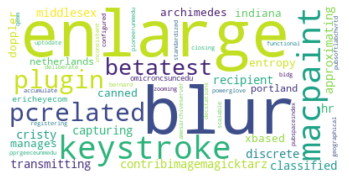

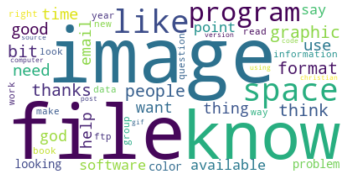

-------------------------------------------------


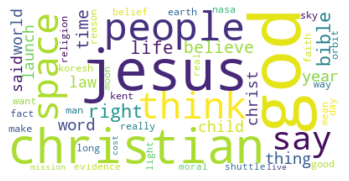

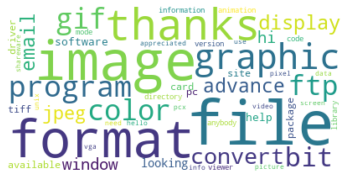

-------------------------------------------------


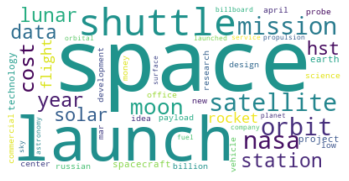

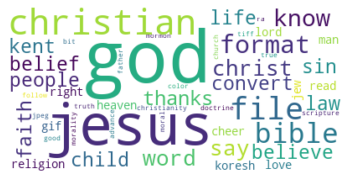

-------------------------------------------------


In [ ]:
for i in range(true_k):
    freq = frequencies_dict(svd, i, True)
    makeImage(freq)
    freq = frequencies_dict(svd, i, False)
    makeImage(freq)
    print("-------------------------------------------------")

The results are now impressive again. Apparently, the "space" topic can be obtained by considering the words that are less correlated with the topic "religion", which also seems to be negatively correlated with "computer graphics"

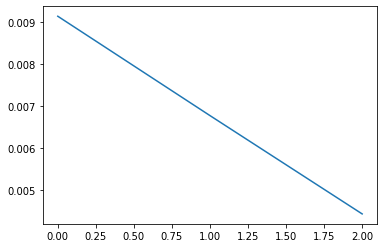

In [ ]:
import matplotlib.pyplot as plt

values = list(svd.explained_variance_ratio_)
values.sort(reverse=True)
plt.plot(values,scaley=True);
plt.show()

In [ ]:
i = 0
total = sum(values)
prefix_sum = values[i]
print(i, total, prefix_sum)
while (prefix_sum < 0.3*total):
    i += 1
    prefix_sum += values[i]
print(i, total, prefix_sum)

0 0.19591029494435794 0.008065214114572977
16 0.19591029494435794 0.0604971365308838


## Take 3: using PCA
We next try to center data first. To this purpose, we use ```sklearn.decomposition.PCA```

In [ ]:
r = true_k
#r = 100
t0 = time()
pca = PCA(n_components=r)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(pca, normalizer)
dense_X = X.todense()
Y = lsa.fit_transform(dense_X)
print("done in %fs" % (time() - t0))
var = 0
print(pca.explained_variance_ratio_)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


done in 2.571439s
[0.0095809  0.00678128 0.00548574]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


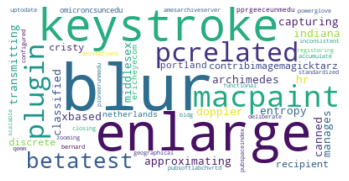

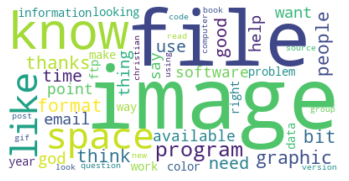

-------------------------------------------------


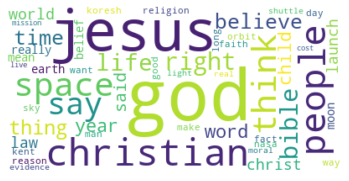

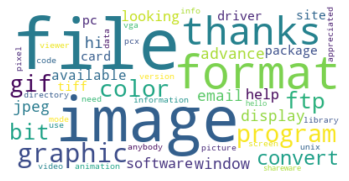

-------------------------------------------------


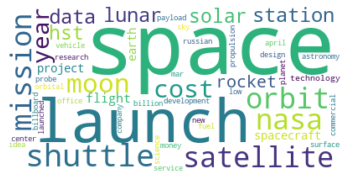

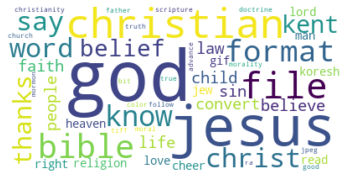

-------------------------------------------------


In [ ]:
for i in range(true_k):
    freq = frequencies_dict(svd, i, True)
    makeImage(freq)
    freq = frequencies_dict(svd, i, False)
    makeImage(freq)
    print("-------------------------------------------------")

The PCA approach also gives very good result in separating the feature space and word cloud.
